In [1]:
import datetime

def hms_string(seconds):
    """ helper function for pretty printing seconds """
    return str(
        datetime.timedelta(
            seconds=seconds
        )
    )

# Convolutional Neural Networks
Convolutional Neural Networks (CNN) are *computer vision* neural networks originally introduced by [Fukushima (1980)](https://www.rctn.org/bruno/public/papers/Fukushima1980.pdf), and refined by [LeCun et al. (1998)](http://yann.lecun.com/exdb/publis/pdf/lecun-bengio-95a.pdf). LeCun et al. introduced an architecture known as LeNet-5, which we will be following in our examples.

Fig 1: LeNet-5 Architecture, LeCun et al.

![](https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg)

CNNs use vector-encoded images as their data sources, and act similarly to [*self-organizing maps* (SOM)](https://en.wikipedia.org/wiki/Self-organizing_map). The element ordering of these vectors is very important, unlike convetionally NN counterparts, where the internal element layout is unimportant.

We will use the [MNIST Digits Data Sets](http://yann.lecun.com/exdb/mnist/). Other commonly used examples are [MNIST Fashion](https://www.kaggle.com/zalando-research/fashionmnist), and [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).

For more information on all of the discussed topics in this notebook, see [CS231n in CNN for Visual Recognition](https://cs231n.github.io/convolutional-networks/).

### Convolution Layers
To construct CNNs, we require a 'new' layer type in our networks. These [*convolutional* layers](https://en.wikipedia.org/wiki/Convolutional_neural_network#Convolutional) have a number of hyper parameters, most commonly

- number of *filters*
- *filter* size
- stride
- padding
- activation function, or *non-linearity*

Convolutional layers are primarily used to detect features in visual data, such as edges, lines, colours, etc., and the more filters in the CNN, the more such features can be detected.

The input is a tensor with shape equal to
$$
\left( \text{Number of Images} \right) \times \left( \text{Image Height} \right) \times \left( \text{Image Width} \right) \times \left( \text{Image Depth} \right).
$$

A *filter* is a square-shaped map, that iteratively scans over an input image. A convolutional layer is comprised of these filters stacked into a grid, and has weights associated between previous layers, the number of weights being commonly equal to the number of pixels. Once can calculate the number of weights between a convolutional layer and a previous convolution layer or image as
$$
\left( \text{Filter Map Height} \right) \times \left( \text{Filter Map Width} \right) \times \left( \text{Number of Filters} \right).
$$

The *padding* of a convolution layer is essentially a layer of zeros around the image data -- like an image border of all white colour.

The *stride* $s$ specifies the pixel offset between each step. These filters move left to right, advancing by $s$ cells, and once they reach the far end, cycle back and drop down $s$ cells. As such, constraints are imposed on the stride; $s > 0$, and $s$ must be less than or equal to the previous grid (or input image) size.

The number of steps a convolution operator takes before it crosses the image can be calculated through
$$
\text{steps} = \frac{w - f + 2p}{s + 1} \in \mathbf{Z^+},
$$
for width $w$, filter width $f$, and padding $p$.

### Pooling Layers
We will specifically be using *Max-Pooling* layers, which are designed to downsample a mutli dimensional image to lower dimensionality (dimensionality in this context may mean the depth of the image, or width / height). Typically, max-pooling layers can immediately follow a convolutional layer, to decrease the image dimensions, and are used to avoid overfitting.

Pooling layers usually have the following hyper parameters:
- spatial extent
- stride

In this context, *spatial extent* $f$ is the size of the box to scale down into a single pixel. Pooling layers have no weights, so are unaffected by training. The width and height of the output are given by
$$
\text{width}_\text{out} = \frac{\text{width}_\text{in} - f}{s + 1}, \ \ \ \text{height}_\text{out} = \frac{\text{height}_\text{in} - f}{ s + 1}.
$$

## TensorFlow CNN
Let us now demonstrate how we can construct and use CNNs with TensorFlow. We will use the MNIST digits data set, which is already formatted into a *train* and *test* set.

In [2]:
import tensorflow as tf

mnist_data = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist_data

print(f"shape of x_train: {x_train.shape}")
print(f"shape of y_train: {y_train.shape}")
print()
print(f"shape of x_test: {x_test.shape}")
print(f"shape of y_test: {y_test.shape}")

11493376/11490434 [==============================] - 1s 0us/step
shape of x_train: (60000, 28, 28)
shape of y_train: (60000,)

shape of x_test: (10000, 28, 28)
shape of y_test: (10000,)


### Examining the data set

We can examine what the data looks like for a single digit:

In [4]:
!pip install pandas

     |████████████████████████████████| 10.5 MB 475 kB/s eta 0:00:01
     |████████████████████████████████| 510 kB 10.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
import numpy as np
import pandas as pd # use for convenience in pretty printing

single = x_train[0]
single_key = y_train[0]
print(f"digit '{single_key}'")

pd.DataFrame(single)

digit '5'


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,...,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,...,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,...,0,0,0,0,0,0,0,0,0,0


Let us visualise this information as a colour map:

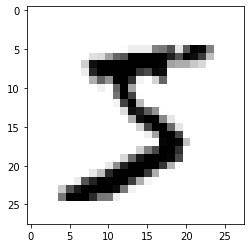

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(single, cmap='gray_r', interpolation='nearest')

We can define a function to provide a more comprehensive overview of several members of the data set:

<Figure size 432x288 with 0 Axes>

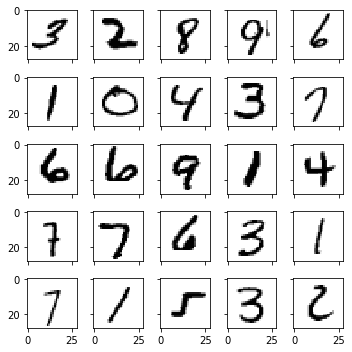

In [7]:
def plot_n_by_n(n):
    """ plot grid of n*n data samples """
    global x_train, y_train
    indices = np.random.choice(
        range(0, x_train.shape[0]),
        size=[n * n]
    )
    imgs = x_train[indices, :]
    
    # clear and create new figure
    plt.clf()
    fig, axs = plt.subplots(
        n, n,
        figsize=(n, n),
        sharex=True, 
        sharey=True
    )
    
    for ax, img in zip(axs.flatten(), imgs):
        ax.imshow(
            img, 
            cmap='gray_r', 
            interpolation='nearest'
        )
    
    plt.tight_layout()
    

plot_n_by_n(5)

### Preparing the data
Before we can use this data, we need to pre-process a little to normalize the data for our neural network. TensorFlow keras may require the image channels first or last, so we can perform a sanity check to ensure our data is correctly formatted:

In [8]:
if tf.keras.backend.image_data_format() == "channels_first":
    print("Channels First")
    re_fmt = lambda i: i.reshape(
        i.shape[0], 
        1, 
        i.shape[1], # rows
        i.shape[2] # cols
    )
else:
    # stack into columnar data
    print("Channels Last")
    re_fmt = lambda i: i.reshape(
        *i.shape,
        1
    )    
    
x_train = re_fmt(x_train)
x_test = re_fmt(x_test)

Channels Last


Next, we want to rescale the data into the range $[0, 1]$, which we can do by casting to float and dividing by 255, the maximum (colour) value:

In [9]:
re_normalize = lambda i: i.astype(np.float32) / 255.0

x_train = re_normalize(x_train)
x_test = re_normalize(x_test)

Print a final overview of our $x$ data:

In [10]:
print(f"shape of x_train: {x_train.shape}")
print(f"training samples: {x_train.shape[0]}")
print(f"test samples: {x_test.shape[0]}")

shape of x_train: (60000, 28, 28, 1)
training samples: 60000
test samples: 10000


Finally, we can use a utility in TensorFlow to categorize our $y$ data into a [binary class matrix](https://keras.rstudio.com/reference/to_categorical.html), similiary to using dummies. In this matrices, the row represents the data, and the column is an the value: the matrix will have one-hot rows to encode the data.

In [11]:
n_classes = np.max(y_train) + 1 # 0 is also a class

y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)

### Building the model
Next we will construct a classfication convolutional sequential neural network, using a combination of convolutional and max-pooling layers:

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        32,
        kernel_size=(3, 3), # kernel == feature
        activation='relu',
        input_shape=x_train.shape[1:]
    ),
    tf.keras.layers.Conv2D(
        64,
        kernel_size=(3, 3),
        activation='relu',
    ),
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2)
    ),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(), # flattens input into single dimension
    tf.keras.layers.Dense(
        128,
        activation='relu'
    ),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense( # output layer
        n_classes,
        activation='softmax'
    )
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

### Training
We train the model with batch gradient update, and set the batch size to 128; this means the gradient will only be adjusted every 128 cycles.

We will time how long the whole process takes:

In [13]:
import time

start_time = time.time()

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=2,
          validation_data=(x_test, y_test)
)
score = model.evaluate(x_test, y_test, verbose=0)

elapsed_time = time.time() - start_time

Epoch 1/12
469/469 - 4s - loss: 0.2387 - accuracy: 0.9277 - val_loss: 0.0535 - val_accuracy: 0.9823
Epoch 2/12
469/469 - 4s - loss: 0.0829 - accuracy: 0.9750 - val_loss: 0.0375 - val_accuracy: 0.9872
Epoch 3/12
469/469 - 4s - loss: 0.0604 - accuracy: 0.9814 - val_loss: 0.0305 - val_accuracy: 0.9898
Epoch 4/12
469/469 - 4s - loss: 0.0508 - accuracy: 0.9841 - val_loss: 0.0317 - val_accuracy: 0.9894
Epoch 5/12
469/469 - 4s - loss: 0.0437 - accuracy: 0.9856 - val_loss: 0.0283 - val_accuracy: 0.9915
Epoch 6/12
469/469 - 4s - loss: 0.0379 - accuracy: 0.9888 - val_loss: 0.0272 - val_accuracy: 0.9906
Epoch 7/12
469/469 - 4s - loss: 0.0342 - accuracy: 0.9895 - val_loss: 0.0249 - val_accuracy: 0.9918
Epoch 8/12
469/469 - 4s - loss: 0.0294 - accuracy: 0.9907 - val_loss: 0.0266 - val_accuracy: 0.9916
Epoch 9/12
469/469 - 4s - loss: 0.0265 - accuracy: 0.9913 - val_loss: 0.0291 - val_accuracy: 0.9912
Epoch 10/12
469/469 - 4s - loss: 0.0246 - accuracy: 0.9922 - val_loss: 0.0281 - val_accuracy: 0.9916

We can now use the model to make a prediction: we will feed it the image we rendered of above, i.e. `x_train[0]`, and decode the prediction using `np.argmax()`.

In [36]:
pred = model.predict(x_train[0:1])
i = np.argmax(pred, axis=1)
print(f"predicted number is {i[0]}.")

predicted number is 5.


### Evaluating the model
We can use the builtin method `.evaluate()` to see how our model performs on the test set:

In [37]:
score = model.evaluate(
    x_test,
    y_test,
    verbose=0
)
print(f"test loss: {score[0]}")
print(f"test accuracy: {score[1]}")

test loss: 0.02736975997686386
test accuracy: 0.9923999905586243
